# 前置作業：套件引用、設計隨機種子確保實驗可重現性等等

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pickle
import os
import random

warnings.filterwarnings('ignore')

In [ ]:
# 設定中文字型
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
# 設定隨機種子以確保可重現性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# 檢查設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用設備: {device}')

使用設備: cuda


# 資料前處理

In [ ]:
class OULADDataLoader:
    def __init__(self, data_path=None):
        self.data_path = data_path
        self.student_info = None
        self.student_vle = None
        self.student_assessment = None
        self.processed_data = None

    def load_data(self):
        """載入數據"""
        if self.data_path is None:
            self.data_path = 'oulad_data'

        try:
            self.student_info = pd.read_csv(os.path.join(self.data_path, 'studentInfo.csv'))
            self.student_vle = pd.read_csv(os.path.join(self.data_path, 'studentVle.csv'))
            self.student_assessment = pd.read_csv(os.path.join(self.data_path, 'studentAssessment.csv'))

            print("✅ 數據載入成功！")
            print(f"學生資訊: {self.student_info.shape}")
            print(f"VLE互動: {self.student_vle.shape}")
            print(f"作業評估: {self.student_assessment.shape}")
        except Exception as e:
            print(f"❌ 數據載入失敗: {e}")

    def preprocess_data(self, sequence_length=6, prediction_length=2):
        """預處理數據，建立序列特徵"""
        print("🧹 開始數據預處理...")

        vle_agg = self.student_vle.groupby(
            ['id_student', 'code_module', 'code_presentation', 'date']
        ).agg({'sum_click': 'sum'}).reset_index()

        vle_agg['week'] = (vle_agg['date'] // 7) + 1

        weekly_clicks = vle_agg.groupby(
            ['id_student', 'code_module', 'code_presentation', 'week']
        ).agg({'sum_click': 'sum'}).reset_index()
        weekly_clicks.rename(columns={'sum_click': 'clicks'}, inplace=True)

        assessments = self.student_assessment.copy()
        assessments['week_submitted'] = (assessments['date_submitted'] // 7) + 1

        weekly_submissions = assessments.groupby(
            ['id_student', 'week_submitted']
        ).agg({'id_assessment': 'count', 'score': 'mean'}).reset_index()
        weekly_submissions.rename(columns={
            'week_submitted': 'week',
            'id_assessment': 'submit_cnt',
            'score': 'avg_score'
        }, inplace=True)

        student_courses = self.student_info[['id_student', 'code_module', 'code_presentation']].drop_duplicates()
        sequences = []

        for _, student_course in student_courses.iterrows():
            student_id = student_course['id_student']
            module = student_course['code_module']
            presentation = student_course['code_presentation']

            student_clicks = weekly_clicks[
                (weekly_clicks['id_student'] == student_id) &
                (weekly_clicks['code_module'] == module) &
                (weekly_clicks['code_presentation'] == presentation)
            ].sort_values('week')

            student_submissions = weekly_submissions[
                weekly_submissions['id_student'] == student_id
            ].sort_values('week')

            if len(student_clicks) < sequence_length + prediction_length:
                continue

            max_week = student_clicks['week'].max()
            week_data = {}

            for week in range(1, max_week + 1):
                week_clicks = student_clicks[student_clicks['week'] == week]
                week_submissions = student_submissions[student_submissions['week'] == week]

                clicks = week_clicks['clicks'].iloc[0] if len(week_clicks) > 0 else 0
                submit_cnt = week_submissions['submit_cnt'].iloc[0] if len(week_submissions) > 0 else 0
                has_submit = 1 if submit_cnt > 0 else 0

                past_scores = student_submissions[student_submissions['week'] <= week]
                avg_score_sofar = past_scores['avg_score'].mean() if len(past_scores) > 0 else 0

                week_data[week] = {
                    'clicks': clicks,
                    'submit_cnt': submit_cnt,
                    'has_submit': has_submit,
                    'avg_score_sofar': avg_score_sofar if not np.isnan(avg_score_sofar) else 0
                }

            for start_week in range(1, max_week - sequence_length - prediction_length + 2):
                sequence = []
                for week in range(start_week, start_week + sequence_length + prediction_length):
                    sequence.append(week_data.get(week, {
                        'clicks': 0, 'submit_cnt': 0, 'has_submit': 0, 'avg_score_sofar': 0
                    }))

                if len(sequence) == sequence_length + prediction_length:
                    sequences.append({
                        'student_id': student_id,
                        'module': module,
                        'presentation': presentation,
                        'sequence': sequence
                    })

        print(f"✅ 生成了 {len(sequences)} 個序列")

        features = []
        targets = []

        for seq_data in sequences:
            sequence = seq_data['sequence']
            input_seq = sequence[:sequence_length]
            target_seq = [week['clicks'] for week in sequence[sequence_length:]]

            feature_seq = []
            for i, week in enumerate(input_seq):
                week_features = [
                    week['clicks'],
                    week['submit_cnt'],
                    week['has_submit'],
                    week['avg_score_sofar']
                ]
                clicks_diff1 = week['clicks'] - input_seq[i-1]['clicks'] if i > 0 else 0
                week_features.append(clicks_diff1)
                feature_seq.append(week_features)

            features.append(feature_seq)
            targets.append(target_seq)

        self.processed_data = {
            'features': np.array(features, dtype=np.float32),
            'targets': np.array(targets, dtype=np.float32),
            'sequences': sequences
        }

        print(f"特徵矩陣形狀: {self.processed_data['features'].shape}")
        print(f"目標矩陣形狀: {self.processed_data['targets'].shape}")
        return self.processed_data

In [ ]:
# ==============================================================================
# 正規化
# ==============================================================================

def preprocess_and_scale(
    X_train, X_val, X_test, y_train, y_val, y_test,
    log_transform_cols_X=[0],  # X：預設第 0 欄是 clicks
    log_transform_cols_y=None, # y：預設不做 log，若提供則針對指定 horizon 做 log1p
    save_path="processed_data"
):
    """
    對特徵與目標資料分別進行 log1p（可選）+ StandardScaler，並儲存結果與 scaler。
    - X：以最後一維為特徵欄位，依 log_transform_cols_X 做 log1p
    - y：以第二維為 horizon，依 log_transform_cols_y 做 log1p
    """
    print("▶ 開始資料前處理與標準化...")

    # ========================
    # Step 1: log1p transform
    # ========================
    if log_transform_cols_X is not None:
        for col in log_transform_cols_X:
            X_train[..., col] = np.log1p(X_train[..., col])
            X_val[..., col]   = np.log1p(X_val[..., col])
            X_test[..., col]  = np.log1p(X_test[..., col])

    if log_transform_cols_y is not None:
        for t in log_transform_cols_y:
            y_train[:, t] = np.log1p(y_train[:, t])
            y_val[:, t]   = np.log1p(y_val[:, t])
            y_test[:, t]  = np.log1p(y_test[:, t])

    # ========================
    # Step 2: Feature scaling
    # ========================
    num_features = X_train.shape[-1]
    scalers_X = []
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    for i in range(num_features):
        scaler_i = StandardScaler()
        X_train_scaled[..., i] = scaler_i.fit_transform(
            X_train[..., i].reshape(-1, 1)
        ).reshape(X_train[..., i].shape)
        X_val_scaled[..., i] = scaler_i.transform(
            X_val[..., i].reshape(-1, 1)
        ).reshape(X_val[..., i].shape)
        X_test_scaled[..., i] = scaler_i.transform(
            X_test[..., i].reshape(-1, 1)
        ).reshape(X_test[..., i].shape)
        scalers_X.append(scaler_i)

    # ========================
    # Step 3: Target scaling
    # ========================
    num_targets = y_train.shape[-1]
    scalers_y = []
    y_train_scaled = y_train.copy()
    y_val_scaled = y_val.copy()
    y_test_scaled = y_test.copy()

    for i in range(num_targets):
        scaler_i = StandardScaler()
        y_train_scaled[:, i] = scaler_i.fit_transform(
            y_train[:, i].reshape(-1, 1)
        ).reshape(-1)
        y_val_scaled[:, i] = scaler_i.transform(
            y_val[:, i].reshape(-1, 1)
        ).reshape(-1)
        y_test_scaled[:, i] = scaler_i.transform(
            y_test[:, i].reshape(-1, 1)
        ).reshape(-1)
        scalers_y.append(scaler_i)

    # ========================
    # Step 4: Save results
    # ========================
    print(f"▶ 儲存處理後資料至 {save_path} ...")

    np.savez_compressed(
        f"{save_path}/scaled_data.npz",
        X_train=X_train_scaled, X_val=X_val_scaled, X_test=X_test_scaled,
        y_train=y_train_scaled, y_val=y_val_scaled, y_test=y_test_scaled
    )

    with open(f"{save_path}/scalers.pkl", "wb") as f:
        pickle.dump({
            "X": scalers_X,
            "y": scalers_y,
            "log_cols_X": log_transform_cols_X,
            "log_cols_y": log_transform_cols_y
        }, f)

    print("✅ 資料處理完成並已儲存")
    return (
        X_train_scaled, X_val_scaled, X_test_scaled,
        y_train_scaled, y_val_scaled, y_test_scaled,
        scalers_X, scalers_y
    )

In [ ]:
# ==============================================================================
# 2. 數據集類別
# ==============================================================================

class SequenceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Seq2Seq LSTM 模型

In [ ]:
# ==============================================================================
# 3. Seq2Seq LSTM 模型
# ==============================================================================

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.1):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # Encoder
        self.encoder = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Decoder: 輸入是 output_size + hidden_size（拼接 context）
        self.decoder = nn.LSTM(
            output_size + hidden_size,  # ✅ 關鍵改進：拼接 encoder context
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # 輸出層加一個中間層
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x, target_length=2, targets=None, teacher_forcing_ratio=0.0):
        batch_size = x.size(0)

        # Encoder: 保留所有層的 hidden 和 cell
        encoder_outputs, (hidden, cell) = self.encoder(x)
        # hidden: (num_layers, B, H)
        # cell: (num_layers, B, H)

        # ✅ 關鍵改進：提取最後一層的 hidden 作為 context
        encoder_context = hidden[-1]  # (B, H)

        # Decoder 初始輸入
        decoder_input = torch.zeros(batch_size, 1, self.output_size, device=x.device)
        outputs = []

        for t in range(target_length):
            # ✅ 關鍵改進：每步拼接 encoder context
            encoder_context_expanded = encoder_context.unsqueeze(1)  # (B, 1, H)
            step_input = torch.cat([decoder_input, encoder_context_expanded], dim=-1)  # (B, 1, output_size+H)

            # Decoder LSTM
            decoder_output, (hidden, cell) = self.decoder(step_input, (hidden, cell))

            # 輸出層
            output = self.output_layer(decoder_output)  # (B, 1, 1)
            outputs.append(output)

            # Teacher forcing
            use_teacher_forcing = self.training and (targets is not None) and (torch.rand(1).item() < teacher_forcing_ratio)
            if use_teacher_forcing:
                decoder_input = targets[:, t].unsqueeze(1).unsqueeze(-1)
            else:
                decoder_input = output.detach()

        outputs = torch.cat(outputs, dim=1)
        return outputs.squeeze(-1)  # (B, T_future)

# Seq2Seq VAE 模型

In [ ]:
# ==============================================================================
# 4. Seq2Seq VAE 模型
# ==============================================================================

class Seq2SeqVAEEncoder(nn.Module):
    """
    改進點：
    1. 使用平均池化而非只用最後 hidden
    2. 增加潛在空間維度
    """
    def __init__(self, feature_dim, hidden_dim, latent_dim, num_layers=2, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # ✅ 改進：使用 2*hidden_dim（結合最後 hidden 和平均）
        self.hidden_to_mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.hidden_to_logvar = nn.Linear(hidden_dim * 2, latent_dim)

    def forward(self, x):
        # x: (B, seq_len, feature_dim)
        lstm_outputs, (h_n, _) = self.lstm(x)

        # ✅ 關鍵改進：結合最後 hidden 和平均池化
        last_hidden = h_n[-1]  # (B, H)
        avg_hidden = lstm_outputs.mean(dim=1)  # (B, H)
        combined = torch.cat([last_hidden, avg_hidden], dim=-1)  # (B, 2H)

        mu = self.hidden_to_mu(combined)
        logvar = self.hidden_to_logvar(combined)

        # 限制 logvar 範圍，防止數值不穩定
        logvar = torch.clamp(logvar, min=-10, max=10)

        return mu, logvar


class Seq2SeqVAEDecoder(nn.Module):
    """
    改進點：
    1. 移除 tanh 激活
    2. 輸出層加中間層
    3. 使用 LayerNorm 穩定初始化
    """
    def __init__(self, output_dim, hidden_dim, latent_dim, future_len):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.future_len = future_len

        # Decoder LSTM
        self.lstm = nn.LSTM(
            input_size=output_dim + latent_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        # ✅ 改進：加入 LayerNorm 穩定初始化
        self.z_to_hidden = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        self.z_to_cell = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )

        # ✅ 改進：輸出層加中間層
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim + latent_dim, hidden_dim // 2),  # 也拼接 z
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, z):
        batch_size = z.size(0)

        # ✅ 關鍵改進：移除 tanh，使用 LayerNorm
        hidden = self.z_to_hidden(z).unsqueeze(0)  # (1, B, H)
        cell = self.z_to_cell(z).unsqueeze(0)      # (1, B, H)

        decoder_input = torch.zeros(batch_size, 1, self.output_dim, device=z.device)
        z_expanded = z.unsqueeze(1)  # (B, 1, latent_dim)

        outputs = []
        for t in range(self.future_len):
            step_input = torch.cat([decoder_input, z_expanded], dim=-1)
            out, (hidden, cell) = self.lstm(step_input, (hidden, cell))

            # ✅ 改進：輸出時也拼接 z
            out_with_z = torch.cat([out, z_expanded], dim=-1)
            pred = self.output_layer(out_with_z)

            outputs.append(pred)
            decoder_input = pred.detach()

        outputs = torch.cat(outputs, dim=1)
        return outputs.squeeze(-1)


class Seq2SeqVAE(nn.Module):
    def __init__(self, feature_dim, hidden_dim, latent_dim, future_len, output_dim=1, num_layers=2, dropout=0.1):
        super().__init__()

        self.encoder = Seq2SeqVAEEncoder(
            feature_dim=feature_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            num_layers=num_layers,
            dropout=dropout
        )

        self.decoder = Seq2SeqVAEDecoder(
            output_dim=output_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            future_len=future_len
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_future = self.decoder(z)
        return recon_future, mu, logvar

# 模型訓練

## LSTM

In [ ]:
# ==============================================================================
# 5. 訓練函數
# ==============================================================================


def train_lstm(
    model,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-3,
    teacher_forcing_start=0.9,
    teacher_forcing_end=0.3,
    warmup_epochs=10,
):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(), lr=lr, weight_decay=1e-6
    )  # ✅ 降低 weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5, verbose=True
    )

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    def get_tf_ratio(epoch_idx):
        if epoch_idx < warmup_epochs:
            # Warmup 階段：固定高 TF
            return teacher_forcing_start

        # 之後線性衰減，但不降到 0
        if epochs - warmup_epochs <= 1:
            return teacher_forcing_end
        progress = (epoch_idx - warmup_epochs) / (epochs - warmup_epochs - 1)
        return (
            teacher_forcing_start
            + (teacher_forcing_end - teacher_forcing_start) * progress
        )

    for epoch in range(epochs):
        tf_ratio = get_tf_ratio(epoch)
        current_lr = optimizer.param_groups[0]["lr"]

        # 訓練
        model.train()
        epoch_train_loss = 0
        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(
                device
            )

            optimizer.zero_grad()
            outputs = model(
                batch_features,
                target_length=batch_targets.size(1),
                targets=batch_targets,
                teacher_forcing_ratio=tf_ratio,
            )
            loss = criterion(outputs, batch_targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # 🔧 放寬梯度裁剪
            optimizer.step()

            epoch_train_loss += loss.item()

        # 驗證
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features, batch_targets = batch_features.to(
                    device
                ), batch_targets.to(device)
                outputs = model(
                    batch_features,
                    target_length=batch_targets.size(1),
                    targets=None,
                    teacher_forcing_ratio=0.0,
                )
                loss = criterion(outputs, batch_targets)
                epoch_val_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # 學習率調整
        scheduler.step(avg_val_loss)

        # 儲存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_lstm_model.pth")

        if epoch % 5 == 0 or epoch == epochs - 1:
            print(
                f"Epoch [{epoch+1}/{epochs}], LR={current_lr:.6f}, TF={tf_ratio:.2f}, "
                f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
            )

    print(f"\n✅ 最佳驗證 Loss: {best_val_loss:.4f}")
    return train_losses, val_losses

## VAE

In [ ]:
def train_vae(
    model,
    train_loader,
    val_loader,
    epochs=50,
    lr=1e-3,
    warmup_epochs=10,
    kl_anneal_epochs=30,
    max_beta=0.1,
):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    train_losses = []
    val_losses = []
    train_recon_losses = []
    train_kl_losses = []
    best_val_loss = float('inf')

    def get_beta(epoch_idx):
        if epoch_idx < warmup_epochs:
            return 0.0  # Warmup 階段不加 KL

        if kl_anneal_epochs <= 0:
            return max_beta

        # 🔧 改用餘弦增長，更平滑的 KL annealing
        progress = min(1.0, (epoch_idx - warmup_epochs) / kl_anneal_epochs)
        return max_beta * (1 - np.cos(progress * np.pi / 2))

    for epoch in range(epochs):
        beta = get_beta(epoch)
        current_lr = optimizer.param_groups[0]['lr']

        # 訓練
        model.train()
        epoch_train_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0

        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

            optimizer.zero_grad()
            reconstruction, mu, logvar = model(batch_features)

            # 重建損失
            recon_loss = F.mse_loss(reconstruction, batch_targets)

            # KL 散度
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            kl_loss = kl_loss / batch_features.size(0)

            # 總損失
            total_loss = recon_loss + beta * kl_loss
            total_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # 🔧 放寬梯度裁剪
            optimizer.step()

            epoch_train_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

        # 驗證
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
                reconstruction, mu, logvar = model(batch_features)

                recon_loss = F.mse_loss(reconstruction, batch_targets)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                kl_loss = kl_loss / batch_features.size(0)

                total_loss = recon_loss + beta * kl_loss
                epoch_val_loss += total_loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_kl_loss = epoch_kl_loss / len(train_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_recon_losses.append(avg_recon_loss)
        train_kl_losses.append(avg_kl_loss)

        # 學習率調整
        scheduler.step(avg_val_loss)

        # 儲存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_vae_model.pth')

        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f'Epoch [{epoch+1}/{epochs}], LR={current_lr:.6f}, beta={beta:.4f}, '
                  f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
                  f'Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}')

    print(f'\n✅ 最佳驗證 Loss: {best_val_loss:.4f}')
    return train_losses, val_losses, train_recon_losses, train_kl_losses

# 模型評估與可視化

In [ ]:
# ==============================================================================
# 6. 評估函數 (修正版：正確反標準化與還原 log)
# ==============================================================================


def evaluate_models(
    lstm_model, vae_model, test_loader, scalers_y, num_vae_samples=20, use_log_y=True
):
    """在原始尺度下評估 LSTM 與 VAE（含多樣本）。
    - 先對預測與真值逐欄位做 inverse_transform（移除標準化）
    - 若 y 曾做過 log1p，則再以 expm1 還原
    """
    lstm_model.eval()
    vae_model.eval()

    lstm_predictions = []
    vae_predictions = []
    vae_samples_all = []
    ground_truth = []

    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_features = batch_features.to(device)
            batch_targets_np = batch_targets.cpu().numpy()

            # LSTM 預測
            lstm_pred_scaled = lstm_model(batch_features)
            lstm_pred_scaled_np = lstm_pred_scaled.cpu().numpy()

            # 反標準化
            lstm_pred_orig = np.zeros_like(lstm_pred_scaled_np)
            gt_orig = np.zeros_like(batch_targets_np)

            for t in range(lstm_pred_scaled_np.shape[1]):
                lstm_pred_orig[:, t] = scalers_y[t].inverse_transform(
                    lstm_pred_scaled_np[:, t].reshape(-1, 1)
                ).ravel()
                gt_orig[:, t] = scalers_y[t].inverse_transform(
                    batch_targets_np[:, t].reshape(-1, 1)
                ).ravel()

            # ✅ 還原 log1p 轉換
            if use_log_y:
                lstm_pred_orig = np.expm1(lstm_pred_orig)
                lstm_pred_orig = np.maximum(lstm_pred_orig, 0)
                gt_orig = np.expm1(gt_orig)
                gt_orig = np.maximum(gt_orig, 0)

            lstm_predictions.append(lstm_pred_orig)

            # VAE 單一路徑預測
            vae_pred_scaled, _, _ = vae_model(batch_features)
            vae_pred_scaled_np = vae_pred_scaled.cpu().numpy()

            vae_pred_orig = np.zeros_like(vae_pred_scaled_np)
            for t in range(vae_pred_scaled_np.shape[1]):
                vae_pred_orig[:, t] = scalers_y[t].inverse_transform(
                    vae_pred_scaled_np[:, t].reshape(-1, 1)
                ).ravel()

            if use_log_y:
                vae_pred_orig = np.expm1(vae_pred_orig)
                vae_pred_orig = np.maximum(vae_pred_orig, 0)

            vae_predictions.append(vae_pred_orig)
            ground_truth.append(gt_orig)

            # VAE 多樣本生成
            batch_size = batch_features.size(0)
            vae_samples_batch = []
            for i in range(batch_size):
                single_input = batch_features[i:i+1]
                samples_scaled = []
                for _ in range(num_vae_samples):
                    sample_scaled, _, _ = vae_model(single_input)
                    samples_scaled.append(sample_scaled.cpu().numpy().reshape(-1))

                samples_scaled_np = np.array(samples_scaled)
                samples_orig = np.zeros_like(samples_scaled_np)

                for t in range(samples_scaled_np.shape[1]):
                    samples_orig[:, t] = scalers_y[t].inverse_transform(
                        samples_scaled_np[:, t].reshape(-1, 1)
                    ).ravel()

                if use_log_y:
                    samples_orig = np.expm1(samples_orig)
                    samples_orig = np.maximum(samples_orig, 0)

                vae_samples_batch.append(samples_orig.tolist())

            vae_samples_all.append(vae_samples_batch)

    # 合併結果
    lstm_predictions = np.concatenate(lstm_predictions, axis=0)
    vae_predictions = np.concatenate(vae_predictions, axis=0)
    ground_truth = np.concatenate(ground_truth, axis=0)

    vae_samples_flat = []
    for batch in vae_samples_all:
        vae_samples_flat.extend(batch)

    # 計算指標
    results = {}
    results['LSTM_MSE'] = mean_squared_error(ground_truth, lstm_predictions)
    results['LSTM_MAE'] = np.mean(np.abs(ground_truth - lstm_predictions))
    results['VAE_MSE'] = mean_squared_error(ground_truth, vae_predictions)
    results['VAE_MAE'] = np.mean(np.abs(ground_truth - vae_predictions))

    # Best-of-N
    best_of_n_mse = []
    for i, gt in enumerate(ground_truth):
        if i < len(vae_samples_flat) and len(vae_samples_flat[i]) > 0:
            sample_mses = [mean_squared_error(gt, sample) for sample in vae_samples_flat[i]]
            best_of_n_mse.append(min(sample_mses))
    results['VAE_Best_of_N_MSE'] = np.mean(best_of_n_mse) if best_of_n_mse else float('inf')

    # Diversity
    diversities = []
    for samples in vae_samples_flat:
        if len(samples) > 1:
            diversities.append(np.std(samples))
    results['VAE_Diversity'] = np.mean(diversities) if diversities else 0

    # Coverage
    coverage_count = 0
    total_count = 0
    for i, gt in enumerate(ground_truth):
        if i < len(vae_samples_flat) and len(vae_samples_flat[i]) > 0:
            samples_np = np.array(vae_samples_flat[i])
            min_vals = samples_np.min(axis=0)
            max_vals = samples_np.max(axis=0)
            for t, gt_val in enumerate(gt):
                if min_vals[t] <= gt_val <= max_vals[t]:
                    coverage_count += 1
                total_count += 1
    results['VAE_Coverage'] = coverage_count / total_count if total_count > 0 else 0

    return results, lstm_predictions, vae_predictions, vae_samples_flat, ground_truth

In [ ]:
# ==============================================================================
# 7. 可視化函數
# ==============================================================================

def plot_training_curves(lstm_losses, vae_losses, vae_recon_losses, vae_kl_losses):
    """繪製訓練曲線"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # LSTM 訓練曲線
    ax1 = axes[0, 0]
    ax1.plot(lstm_losses[0], label='Train Loss', color='blue', linewidth=2)
    ax1.plot(lstm_losses[1], label='Val Loss', color='orange', linewidth=2)
    ax1.set_title('LSTM 訓練曲線', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # VAE 總損失曲線
    ax2 = axes[0, 1]
    ax2.plot(vae_losses[0], label='Train Loss', color='green', linewidth=2)
    ax2.plot(vae_losses[1], label='Val Loss', color='red', linewidth=2)
    ax2.set_title('VAE 訓練曲線（總損失）', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Total Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # VAE 重建損失
    ax3 = axes[1, 0]
    ax3.plot(vae_recon_losses, label='Reconstruction Loss', color='purple', linewidth=2)
    ax3.set_title('VAE 重建損失', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('MSE Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # VAE KL 散度
    ax4 = axes[1, 1]
    ax4.plot(vae_kl_losses, label='KL Divergence', color='brown', linewidth=2)
    ax4.set_title('VAE KL 散度', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('KL Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def plot_predictions(ground_truth, lstm_pred, vae_pred, vae_samples, num_examples=5):
    """可視化預測結果"""
    fig, axes = plt.subplots(num_examples, 1, figsize=(14, 3.5*num_examples))
    if num_examples == 1:
        axes = [axes]

    for i in range(min(num_examples, len(ground_truth))):
        ax = axes[i]
        time_points = range(len(ground_truth[i]))

        # 真實值
        ax.plot(time_points, ground_truth[i], 'ko-', label='Ground Truth',
                linewidth=3, markersize=8, zorder=5)

        # LSTM 預測
        ax.plot(time_points, lstm_pred[i], 'bs-', label='LSTM',
                linewidth=2.5, markersize=7, alpha=0.8, zorder=4)

        # VAE 單一預測
        ax.plot(time_points, vae_pred[i], 'r^-', label='VAE (Single)',
                linewidth=2.5, markersize=7, alpha=0.8, zorder=3)

        # VAE 多樣本
        if i < len(vae_samples) and len(vae_samples[i]) > 0:
            for j, sample in enumerate(vae_samples[i]):
                if len(sample) == len(time_points):
                    alpha = 0.15
                    color = 'lightcoral'
                    label = f'VAE Samples (n={len(vae_samples[i])})' if j == 0 else None
                    ax.plot(time_points, sample, color=color, alpha=alpha,
                           linewidth=1.5, label=label, zorder=1)

        ax.set_title(f'預測範例 {i+1}', fontsize=12, fontweight='bold')
        ax.set_xlabel('週數', fontsize=11)
        ax.set_ylabel('點擊次數', fontsize=11)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_evaluation_metrics(results):
    """繪製評估指標比較"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # MSE 比較
    ax1 = axes[0]
    metrics = ['LSTM_MSE', 'VAE_MSE', 'VAE_Best_of_N_MSE']
    values = [results[metric] for metric in metrics]
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax1.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.set_title('MSE 比較', fontsize=14, fontweight='bold')
    ax1.set_ylabel('MSE', fontsize=12)
    ax1.tick_params(axis='x', rotation=15)

    # 在柱狀圖上標註數值
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # MAE 比較
    ax2 = axes[1]
    mae_metrics = ['LSTM_MAE', 'VAE_MAE']
    mae_values = [results[metric] for metric in mae_metrics]
    bars = ax2.bar(mae_metrics, mae_values, color=['#3498db', '#e74c3c'],
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    ax2.set_title('MAE 比較', fontsize=14, fontweight='bold')
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.tick_params(axis='x', rotation=15)

    for bar, val in zip(bars, mae_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # VAE 特有指標
    ax3 = axes[2]
    vae_metrics = ['VAE_Diversity', 'VAE_Coverage']
    vae_values = [results[metric] for metric in vae_metrics]
    bars = ax3.bar(vae_metrics, vae_values, color=['#9b59b6', '#f39c12'],
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.set_title('VAE 多樣性指標', fontsize=14, fontweight='bold')
    ax3.set_ylabel('分數', fontsize=12)
    ax3.tick_params(axis='x', rotation=15)

    for bar, val in zip(bars, vae_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# 主程式

In [ ]:

# =====================================================
# 1. 載入原始 OULAD 資料 + 基本處理
# =====================================================
data_loader = OULADDataLoader()
data_loader.load_data()
processed_data = data_loader.preprocess_data(sequence_length=4, prediction_length=2)

features = processed_data['features']
targets = processed_data['targets']

# =====================================================
# 2. 按學生 ID 分割訓練 / 驗證 / 測試
# =====================================================
student_ids = [seq['student_id'] for seq in processed_data['sequences']]
unique_students = list(set(student_ids))

train_students, test_students = train_test_split(unique_students, test_size=0.2, random_state=42)
train_students, val_students = train_test_split(train_students, test_size=0.2, random_state=42)

train_indices = [i for i, sid in enumerate(student_ids) if sid in train_students]
val_indices = [i for i, sid in enumerate(student_ids) if sid in val_students]
test_indices = [i for i, sid in enumerate(student_ids) if sid in test_students]

X_train, y_train = features[train_indices], targets[train_indices]
X_val, y_val = features[val_indices], targets[val_indices]
X_test, y_test = features[test_indices], targets[test_indices]

print(f"訓練集: {X_train.shape}, 驗證集: {X_val.shape}, 測試集: {X_test.shape}")

# =====================================================
# 3. 資料正規化（抽出成獨立函式）
# =====================================================
processed_dir = "processed_data"
os.makedirs(processed_dir, exist_ok=True)
scaled_npz_path = os.path.join(processed_dir, "scaled_data.npz")
scaler_pkl_path = os.path.join(processed_dir, "scalers.pkl")

# 強制重新產生 scaled 資料（修正 y 全部 horizon 皆 log1p）
force_rescale = True

if force_rescale or not os.path.exists(scaled_npz_path):
    # 第一次或強制重建 → 跑 log1p + StandardScaler 並存檔
    log_cols_X = [0]  # X 的第 0 欄是 clicks
    log_cols_y = list(range(y_train.shape[1]))  # y 所有 horizon 都 log1p
    (X_train_scaled, X_val_scaled, X_test_scaled,
        y_train_scaled, y_val_scaled, y_test_scaled,
        scalers_X, scalers_y) = preprocess_and_scale(
        X_train, X_val, X_test,
        y_train, y_val, y_test,
        log_transform_cols_X=log_cols_X,
        log_transform_cols_y=log_cols_y,
        save_path=processed_dir
    )
else:
    # 之後直接讀取處理過的資料
    data = np.load(scaled_npz_path)
    X_train_scaled = data["X_train"]
    X_val_scaled   = data["X_val"]
    X_test_scaled  = data["X_test"]
    y_train_scaled = data["y_train"]
    y_val_scaled   = data["y_val"]
    y_test_scaled  = data["y_test"]

    with open(scaler_pkl_path, "rb") as f:
        scalers = pickle.load(f)
    scalers_X = scalers["X"]
    scalers_y = scalers["y"]
    print("✅ 已載入處理後資料與 Scaler")

# =====================================================
# 4. 建立 Dataset 與 DataLoader
# =====================================================
train_dataset = SequenceDataset(X_train_scaled, y_train_scaled)
val_dataset = SequenceDataset(X_val_scaled, y_val_scaled)
test_dataset = SequenceDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

✅ 數據載入成功！
學生資訊: (32593, 12)
VLE互動: (10655280, 6)
作業評估: (173912, 5)
🧹 開始數據預處理...
✅ 生成了 612496 個序列
特徵矩陣形狀: (612496, 4, 5)
目標矩陣形狀: (612496, 2)
訓練集: (392020, 4, 5), 驗證集: (98038, 4, 5), 測試集: (122438, 4, 5)
▶ 開始資料前處理與標準化...
▶ 儲存處理後資料至 processed_data ...
✅ 資料處理完成並已儲存


LSTM 模型參數數量: 474,241
VAE 模型參數數量: 298,913

【步驟 6】開始訓練 LSTM 模型...
Epoch [1/50], LR=0.005000, TF=0.90, Train Loss: 0.6786, Val Loss: 0.6943
Epoch [6/50], LR=0.005000, TF=0.90, Train Loss: 0.6658, Val Loss: 0.6909
Epoch [11/50], LR=0.005000, TF=0.90, Train Loss: 0.6637, Val Loss: 0.6870
Epoch [16/50], LR=0.005000, TF=0.90, Train Loss: 0.6621, Val Loss: 0.6973
Epoch [21/50], LR=0.002500, TF=0.84, Train Loss: 0.6593, Val Loss: 0.6868
Epoch [26/50], LR=0.001250, TF=0.78, Train Loss: 0.6571, Val Loss: 0.6880
Epoch [31/50], LR=0.001250, TF=0.72, Train Loss: 0.6565, Val Loss: 0.6891
Epoch [36/50], LR=0.000625, TF=0.66, Train Loss: 0.6554, Val Loss: 0.6923
Epoch [41/50], LR=0.000313, TF=0.61, Train Loss: 0.6525, Val Loss: 0.6934
Epoch [46/50], LR=0.000156, TF=0.55, Train Loss: 0.6501, Val Loss: 0.6957
Epoch [50/50], LR=0.000078, TF=0.50, Train Loss: 0.6496, Val Loss: 0.6973

✅ 最佳驗證 Loss: 0.6868

【步驟 7】開始訓練 VAE 模型...
Epoch [1/50], LR=0.005000, beta=0.0000, Train Loss: 0.7041, Val Loss: 0.6966, Rec

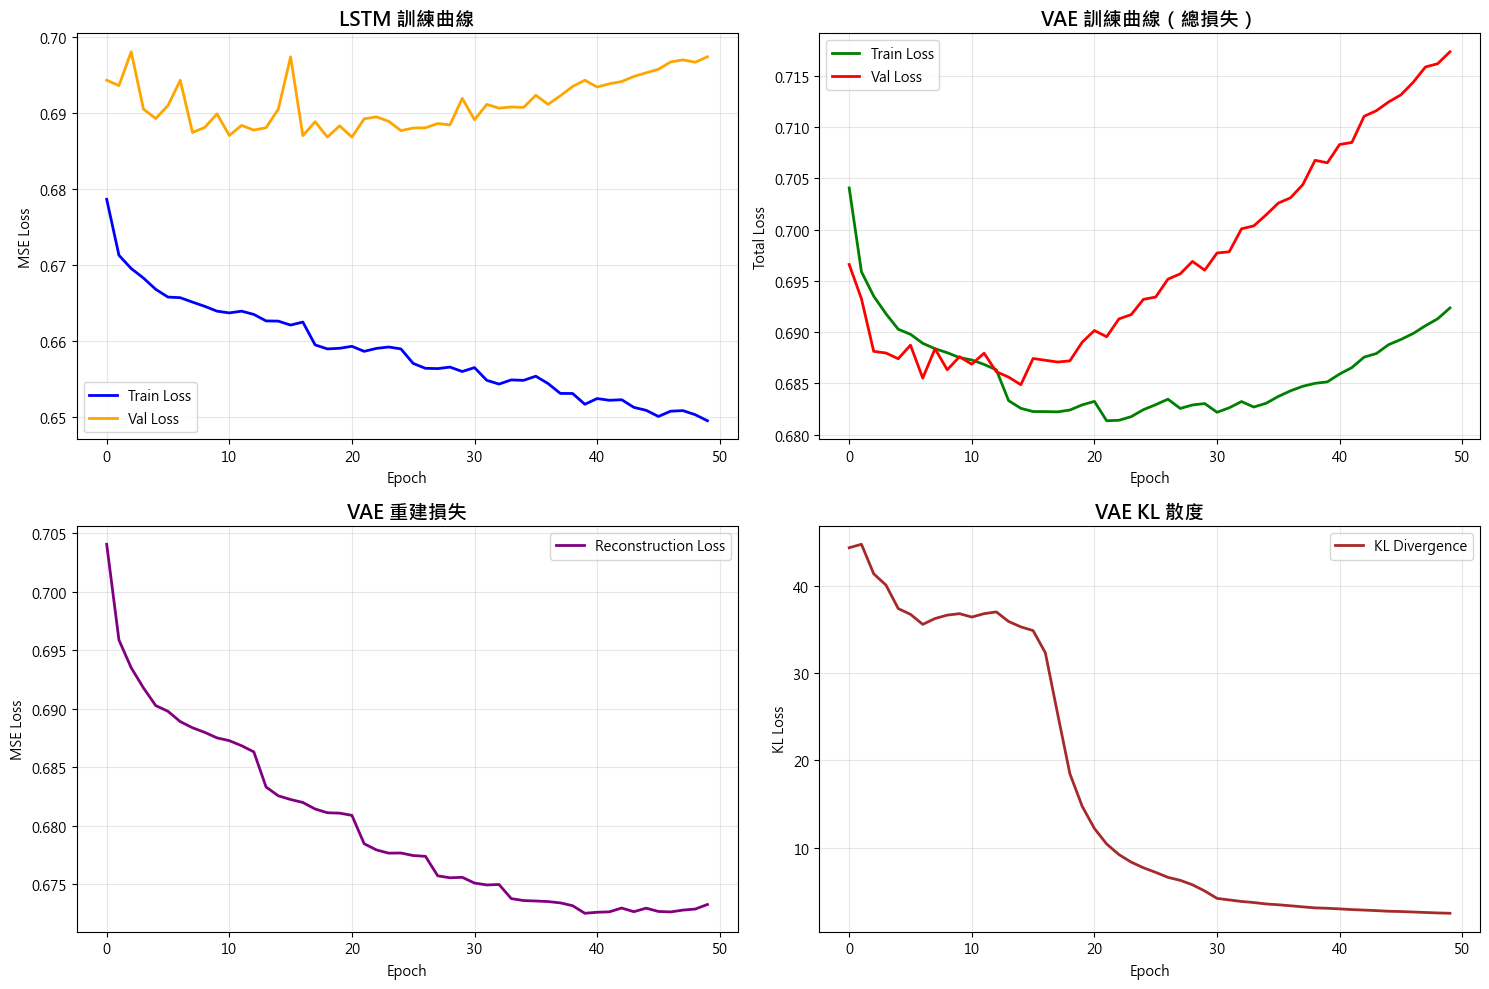

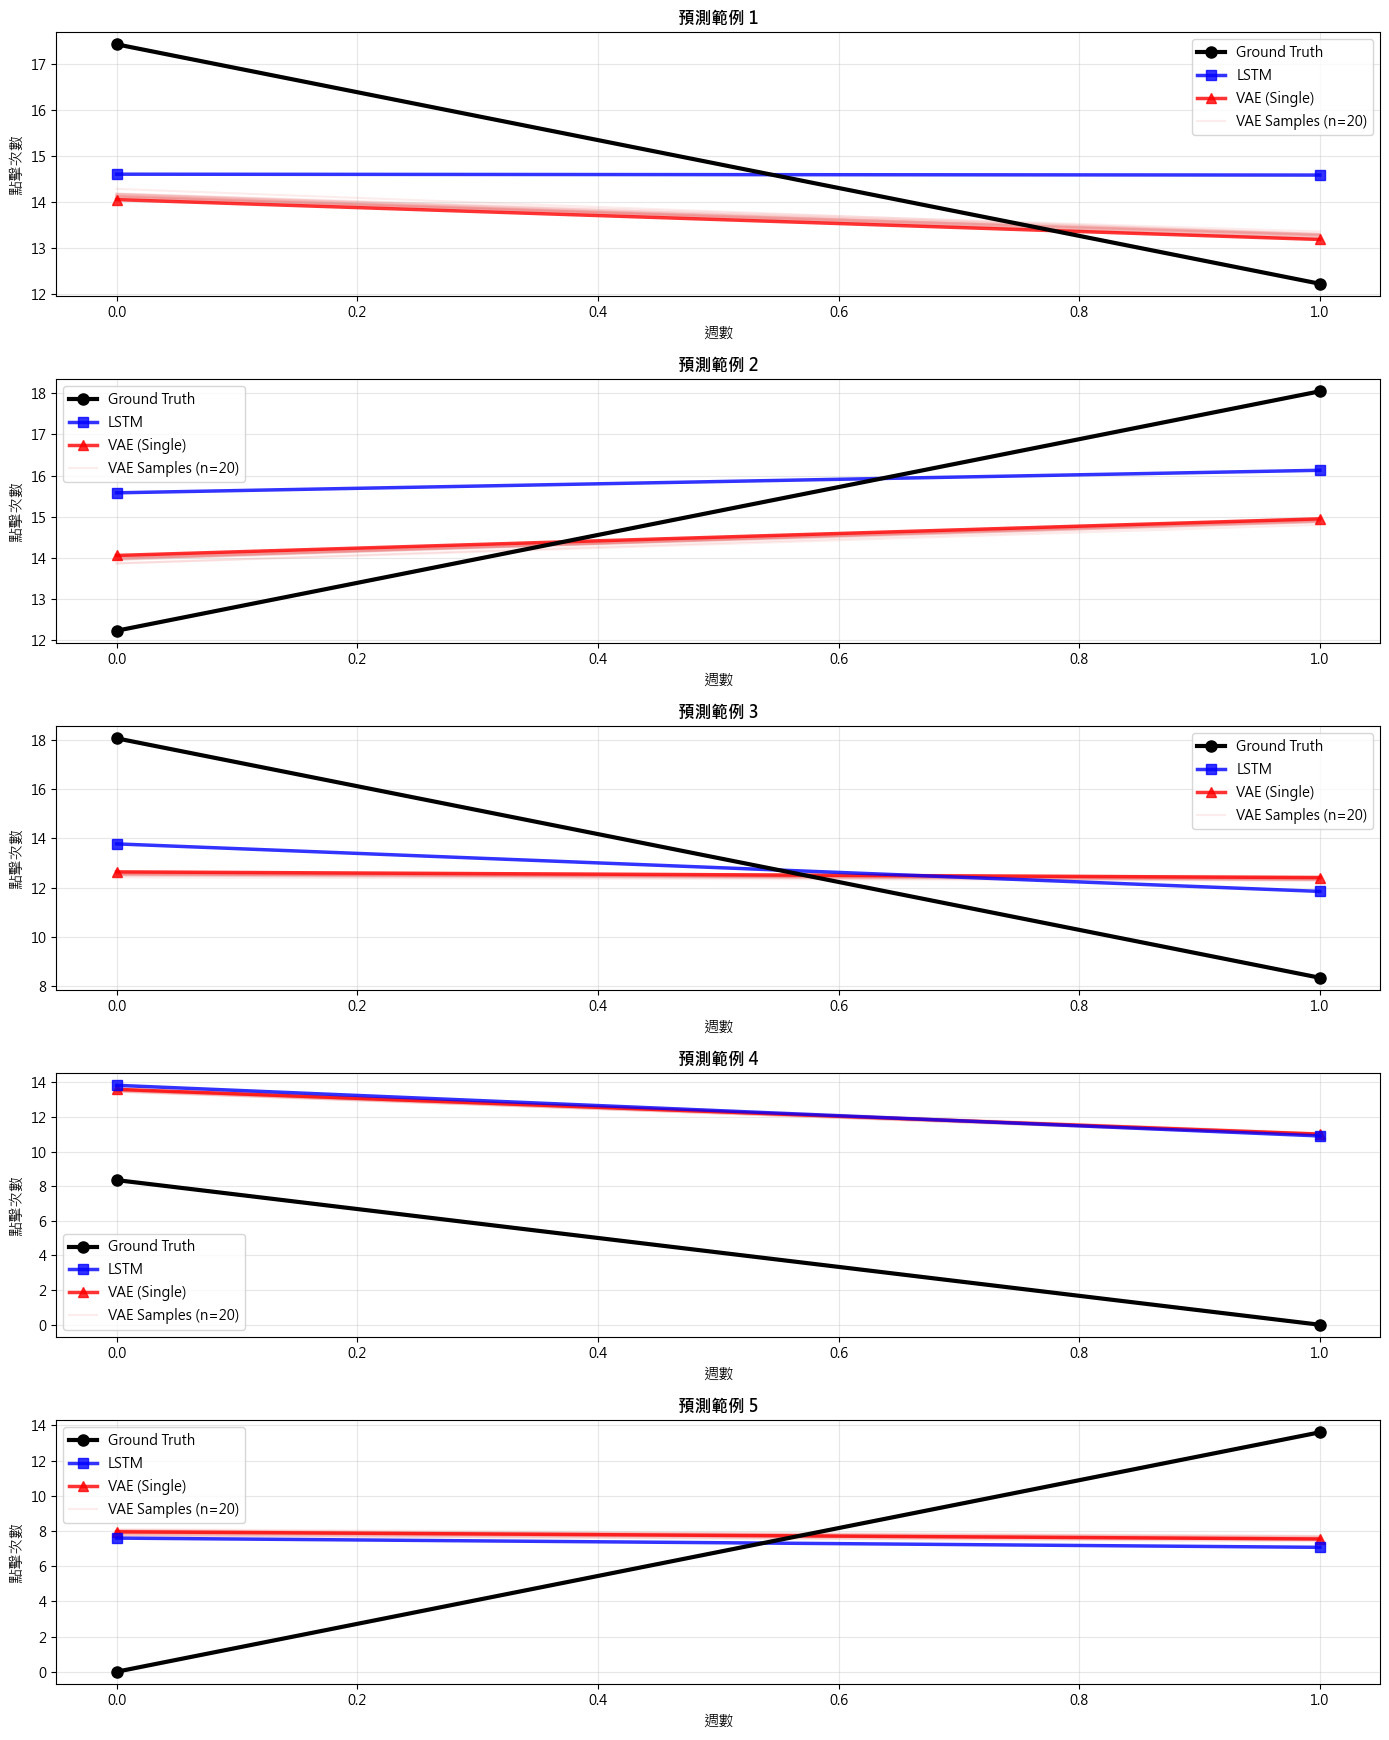

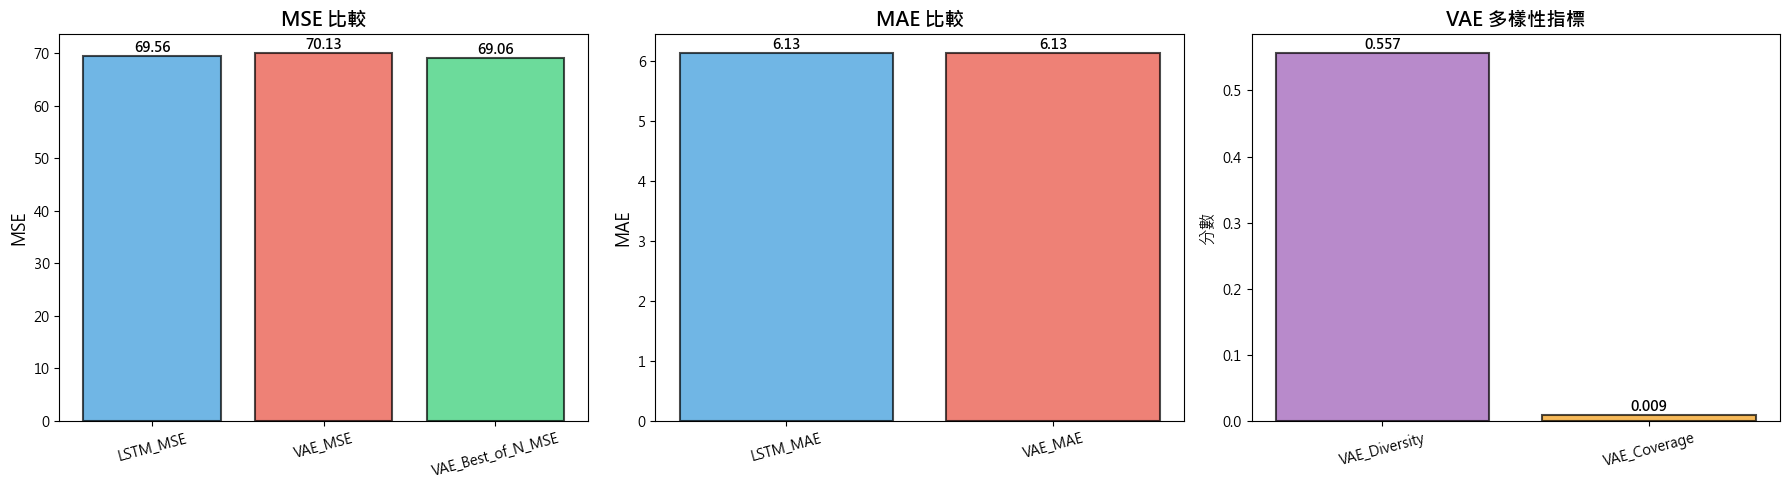


✅ 所有步驟完成！


In [ ]:
input_size = X_train.shape[-1]
hidden_size = 128       # 🔧 增加模型容量，提升學習能力
latent_size = 16        # 🔧 降低潛在空間維度，避免過度複雜
future_len = y_train.shape[1]
output_size = 1
num_layers = 2
dropout_rate = 0.1      # 降低 dropout
lr = 5e-3               # 🔧 大幅提升學習率

lstm_model = Seq2SeqLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers,
    dropout=dropout_rate
).to(device)

vae_model = Seq2SeqVAE(
    feature_dim=input_size,
    hidden_dim=hidden_size,
    latent_dim=latent_size,
    future_len=future_len,
    output_dim=output_size,
    num_layers=num_layers,
    dropout=dropout_rate
).to(device)

print(f"LSTM 模型參數數量: {sum(p.numel() for p in lstm_model.parameters()):,}")
print(f"VAE 模型參數數量: {sum(p.numel() for p in vae_model.parameters()):,}")

# 6. 訓練模型
print("\n" + "="*80)
print("【步驟 6】開始訓練 LSTM 模型...")
print("="*80)
lstm_losses = train_lstm(
    lstm_model, train_loader, val_loader,
    epochs=50,
    lr=lr,
    teacher_forcing_start=0.9,
    teacher_forcing_end=0.5,  # 🔧 不降到太低，保持學習能力
    warmup_epochs=15          # 🔧 更長的 warmup 週期
)

print("\n" + "="*80)
print("【步驟 7】開始訓練 VAE 模型...")
print("="*80)
vae_losses_full = train_vae(
    vae_model, train_loader, val_loader,
    epochs=50,
    lr=lr,
    warmup_epochs=15,      # 🔧 增加 warmup 週期
    kl_anneal_epochs=40,   # 🔧 更平滑的 annealing
    max_beta=0.01          # 🔧 大幅降低 KL 權重
)

vae_losses = vae_losses_full[:2]
vae_recon_losses = vae_losses_full[2]
vae_kl_losses = vae_losses_full[3]

# 7. 載入最佳模型
print("\n【步驟 8】載入最佳模型...")
lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))
vae_model.load_state_dict(torch.load('best_vae_model.pth'))




【步驟 9】評估模型...

【最終評估結果】
LSTM_MSE                 : 7540.8027
LSTM_MAE                 : 37.3175
VAE_MSE                  : 7559.5518
VAE_MAE                  : 37.3307
VAE_Best_of_N_MSE        : 7520.7198
VAE_Diversity            : 2.3475
VAE_Coverage             : 0.0087

【步驟 10】生成可視化圖表...


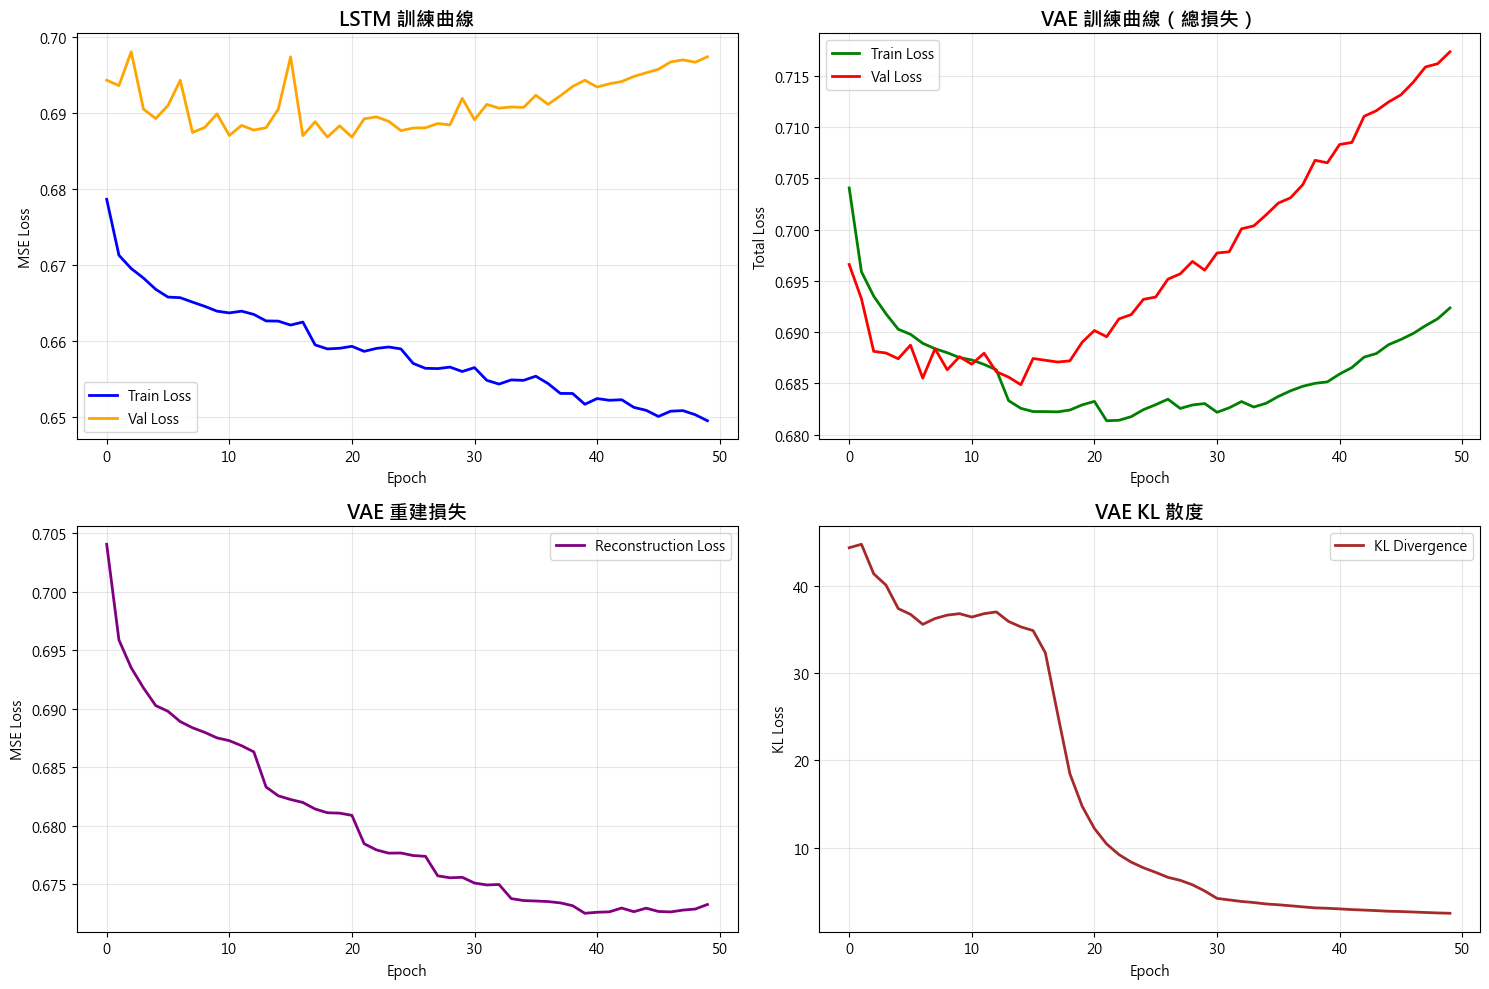

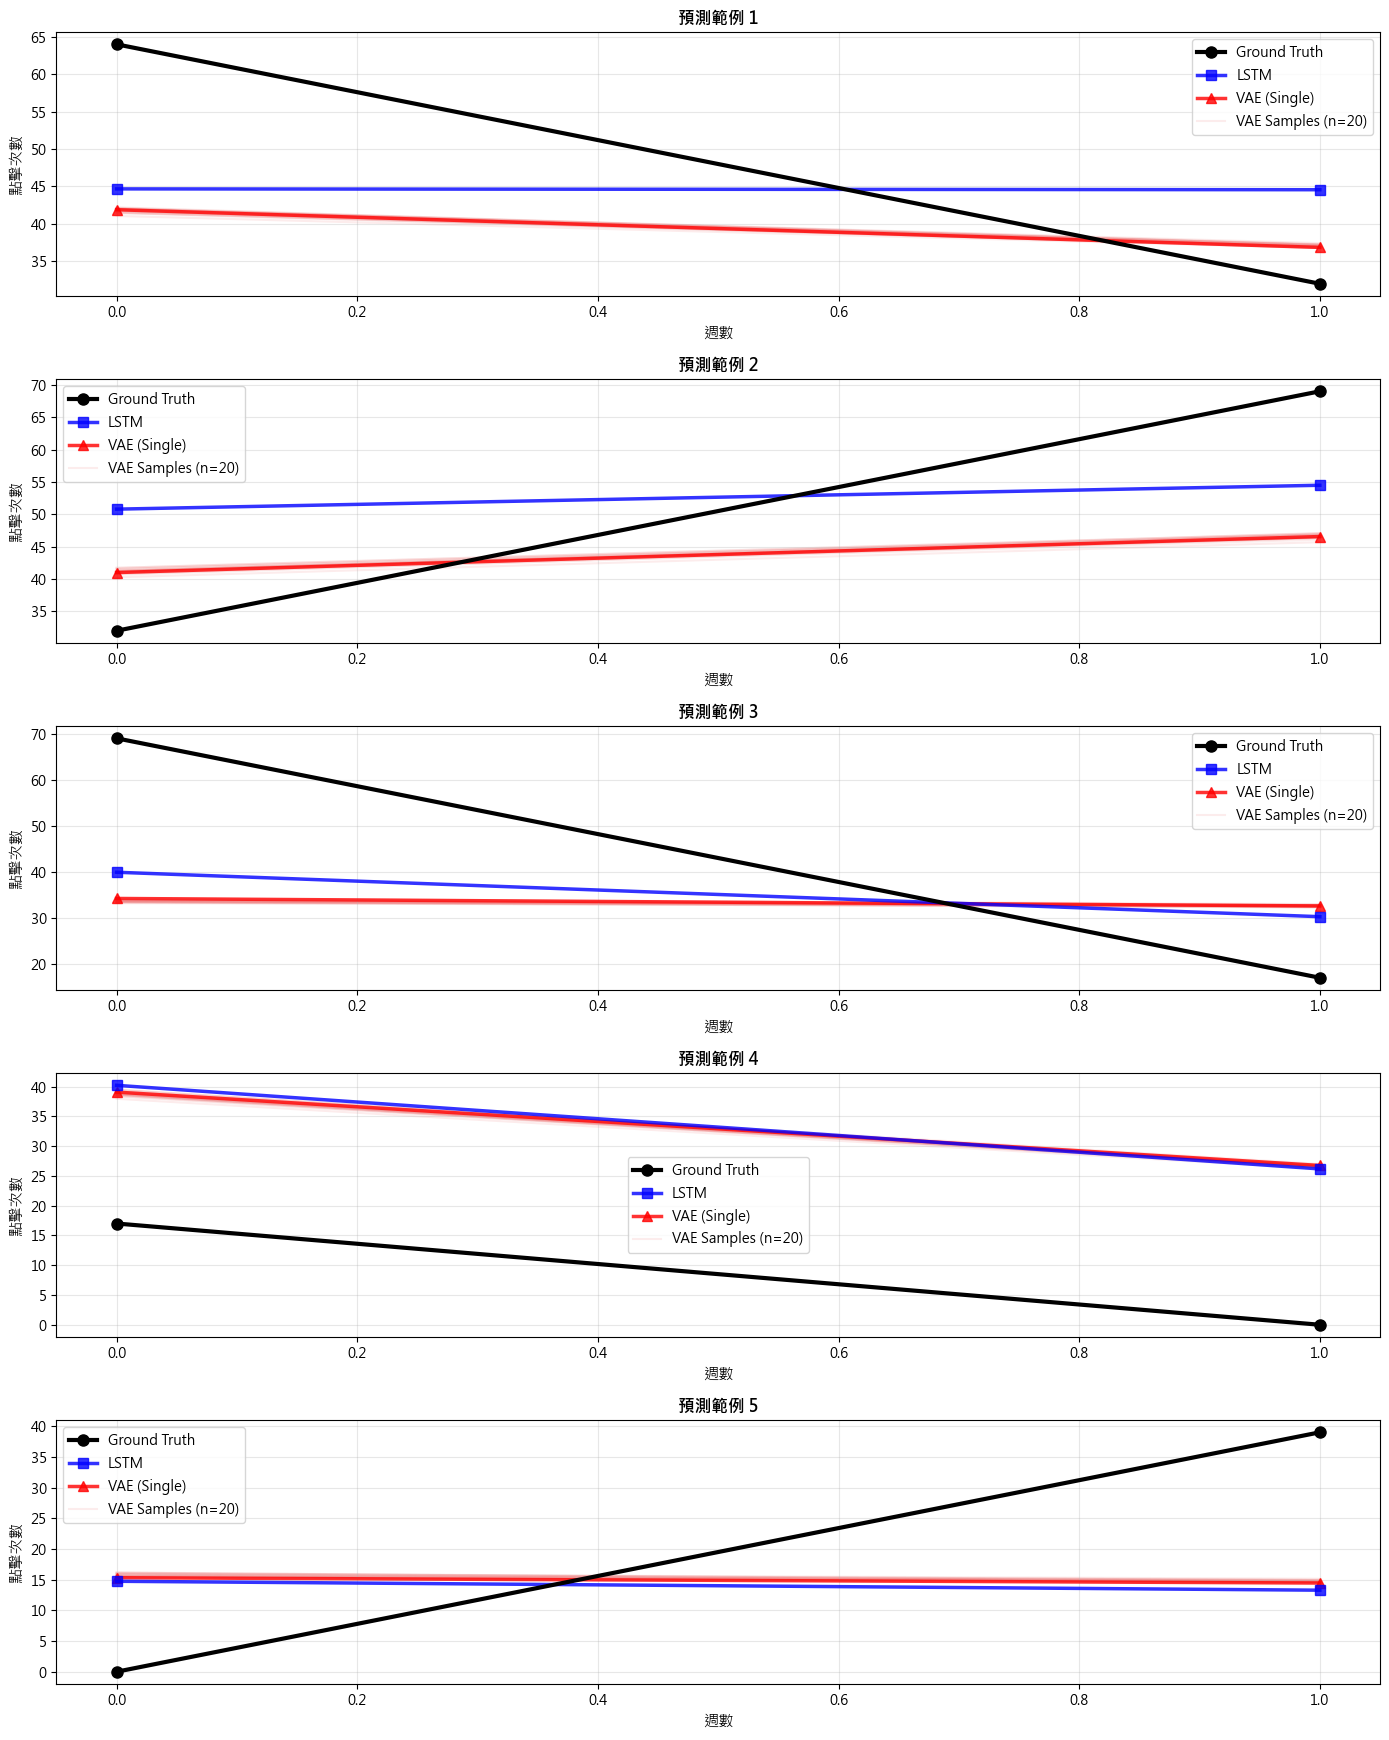

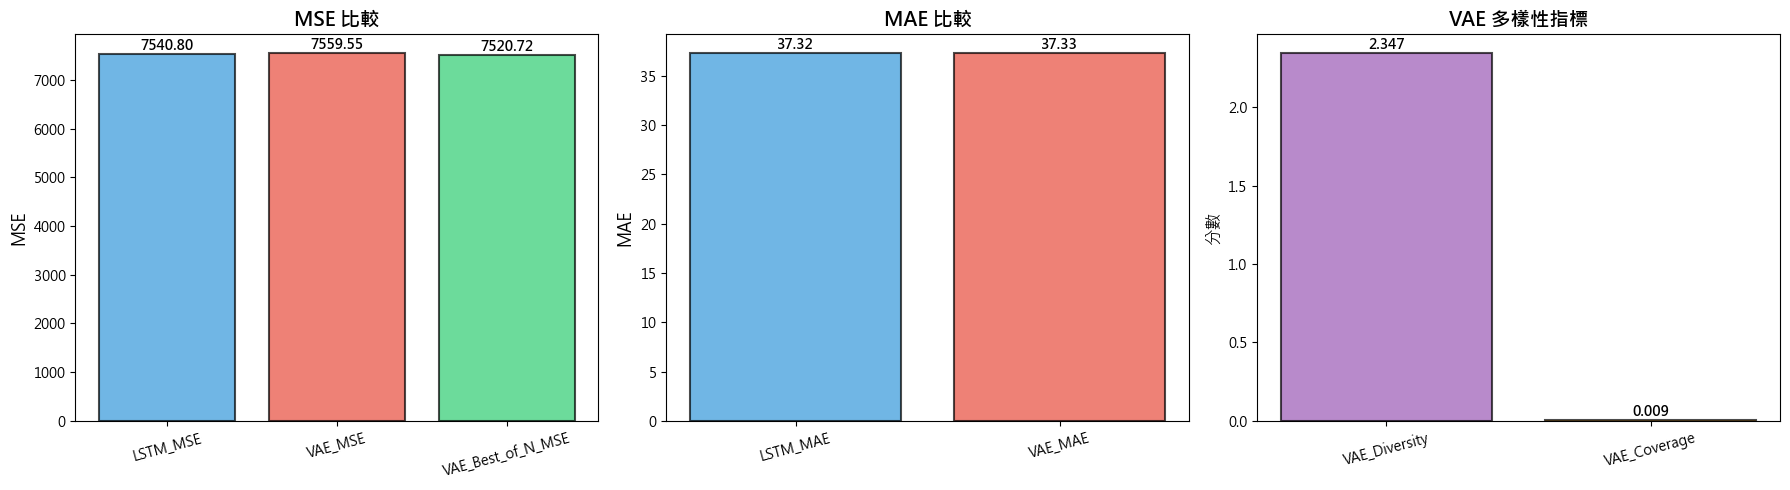


✅ 所有步驟完成！


In [ ]:
# 8. 評估模型
print("\n【步驟 9】評估模型...")
results, lstm_pred, vae_pred, vae_samples, gt = evaluate_models(
    lstm_model, vae_model, test_loader, scalers_y,
    num_vae_samples=20,
    use_log_y=True
)

# 9. 輸出結果
print("\n" + "="*80)
print("【最終評估結果】")
print("="*80)
for metric, value in results.items():
    print(f"{metric:25s}: {value:.4f}")

# 10. 可視化
print("\n【步驟 10】生成可視化圖表...")
plot_training_curves(lstm_losses, vae_losses, vae_recon_losses, vae_kl_losses)
plot_predictions(gt, lstm_pred, vae_pred, vae_samples, num_examples=5)
plot_evaluation_metrics(results)

print("\n" + "="*80)
print("✅ 所有步驟完成！")
print("="*80)